## Assignment 7
### Meenu Ravi
### May 22 2021

#### Question 1: 10 pointsBuild your own CNN from scratch and try to achieve the highest possible accu-racy on MNIST.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_valid = y_train[:-5000], y_train[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [52]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 881s 505ms/step - loss: 0.3694 - accuracy: 0.8852 - val_loss: 0.0495 - val_accuracy: 0.9860
Epoch 2/10
1719/1719 [==============================] - 837s 487ms/step - loss: 0.0800 - accuracy: 0.9761 - val_loss: 0.0396 - val_accuracy: 0.9874
Epoch 3/10
1719/1719 [==============================] - 832s 484ms/step - loss: 0.0626 - accuracy: 0.9811 - val_loss: 0.0504 - val_accuracy: 0.9874
Epoch 4/10
1719/1719 [==============================] - 816s 475ms/step - loss: 0.0498 - accuracy: 0.9852 - val_loss: 0.0332 - val_accuracy: 0.9912
Epoch 5/10
1719/1719 [==============================] - 825s 480ms/step - loss: 0.0416 - accuracy: 0.9869 - val_loss: 0.0368 - val_accuracy: 0.9910
Epoch 6/10
1719/1719 [==============================] - 829s 482ms/step - loss: 0.0373 - accuracy: 0.9888 - val_loss: 0.0352 - val_accuracy: 0.9906
Epoch 7/10
1719/1719 [==============================] - 987s 574ms/step - loss: 0.0310 - accuracy: 0.9894 - val_

In [ ]:
model.evaluate(X_test, y_test)

#### Question 2: 50 pointsUse transfer learning for large image classification, going through these steps:

#### •Create  a  training  set  containing  at  least  100  images  per  class.   For  ex-ample, you could classify your own pictures based on the location (beach,mountain, city, etc.), or alternatively you can use an existing dataset (e.g.,from TensorFlow Datasets).

#### •Split it into a training set, a validation set, and a test set.

#### •Build the input pipeline, including the appropriate preprocessing opera-tions, and optionally add data augmentation.

#### •Fine-tune a pretrained model on this dataset.

#### •Considering that you are using your own dataset, make sure to explain inthe notebook what you are doing, show example pictures so that a readercan easily understand what’s going on.

I used the dogs and cats data set where each image is 160x160 pixels

In [3]:
import os
zip_ = tf.keras.utils.get_file('cats_and_dogs.zip', 
                                      origin='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', 
                                      extract=True)
PATH = os.path.join(os.path.dirname(zip_), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

Splitting in train and validation set

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [5]:
validation = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Here, I show a few images from the dogs and cats dataset

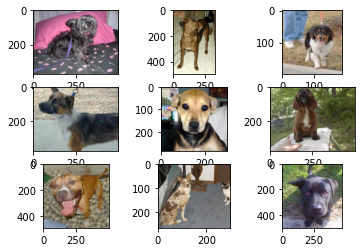

In [6]:
from matplotlib import pyplot
from matplotlib.image import imread
folder = train_dir+ "\\dogs\\"
# plot first few images
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
#     print(filename)
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

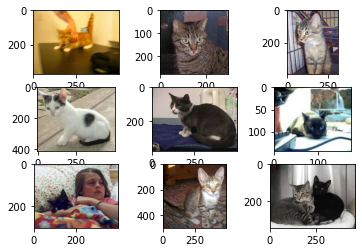

In [7]:
from matplotlib import pyplot
from matplotlib.image import imread
folder = train_dir+ "\\cats\\"
# plot first few images
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
#     print(filename)
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

In [45]:
class_names = train.class_names

test = validation.take(tf.data.experimental.cardinality(validation) // 5)
valid = validation.skip(tf.data.experimental.cardinality(validation) // 5)

Pre processing the input

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

This is a pretrained model: freeze the bottom layers and evaluate the model by looking at the summary. Then look at the validation set evaluation

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

block_6_expand_BN (BatchNormali (None, 20, 20, 192)  768         block_6_expand[0][0]             
__________________________________________________________________________________________________
block_6_expand_relu (ReLU)      (None, 20, 20, 192)  0           block_6_expand_BN[0][0]          
__________________________________________________________________________________________________
block_6_pad (ZeroPadding2D)     (None, 21, 21, 192)  0           block_6_expand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_de

block_12_add (Add)              (None, 10, 10, 96)   0           block_11_add[0][0]               
                                                                 block_12_project_BN[0][0]        
__________________________________________________________________________________________________
block_13_expand (Conv2D)        (None, 10, 10, 576)  55296       block_12_add[0][0]               
__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 10, 10, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 10, 10, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 11, 11, 576)  0           block_13_expand_relu[0][0]       
__________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
average = global_average_layer(base_model.output)

In [15]:
output = tf.keras.layers.Dense(1)(average)

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [23]:
initial_epochs = 10

In [24]:
history = model.fit(train,
                    epochs=initial_epochs,
                    validation_data=validation)

Epoch 1/10
63/63 [==============================] - 371s 5s/step - loss: 0.6992 - accuracy: 0.5577 - val_loss: 0.4647 - val_accuracy: 0.7050
Epoch 2/10
63/63 [==============================] - 258s 4s/step - loss: 0.4489 - accuracy: 0.7310 - val_loss: 0.3273 - val_accuracy: 0.8480
Epoch 3/10
63/63 [==============================] - 280s 4s/step - loss: 0.3349 - accuracy: 0.8419 - val_loss: 0.2502 - val_accuracy: 0.9010
Epoch 4/10
63/63 [==============================] - 269s 4s/step - loss: 0.2632 - accuracy: 0.8955 - val_loss: 0.2026 - val_accuracy: 0.9330
Epoch 5/10
63/63 [==============================] - 252s 4s/step - loss: 0.2230 - accuracy: 0.9081 - val_loss: 0.1717 - val_accuracy: 0.9480
Epoch 6/10
63/63 [==============================] - 247s 4s/step - loss: 0.1853 - accuracy: 0.9214 - val_loss: 0.1503 - val_accuracy: 0.9540
Epoch 7/10
63/63 [==============================] - 251s 4s/step - loss: 0.1662 - accuracy: 0.9379 - val_loss: 0.1339 - val_accuracy: 0.9640
Epoch 8/10
63

Text(0, 0.5, 'Accuracy')

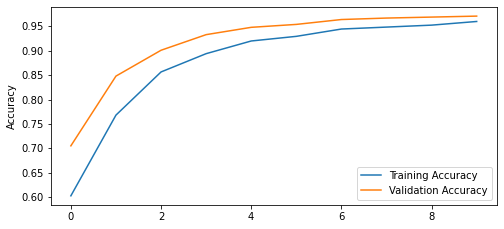

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')


Unfreeze layers

In [30]:
for layer in base_model.layers:
    layer.trainable = True

In [31]:
len(base_model.layers)

154

In [32]:
fine_tune_at = 100

For layers before 100th layers, I freeze them

In [33]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

Fit the fine tuned parameters model

In [37]:
total_epochs =  20

history_fine = model.fit(train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

Epoch 10/20
63/63 [==============================] - 446s 7s/step - loss: 0.0715 - accuracy: 0.9776 - val_loss: 0.0399 - val_accuracy: 0.9850
Epoch 11/20
63/63 [==============================] - 341s 5s/step - loss: 0.0268 - accuracy: 0.9907 - val_loss: 0.0442 - val_accuracy: 0.9810
Epoch 12/20
63/63 [==============================] - 333s 5s/step - loss: 0.0101 - accuracy: 0.9978 - val_loss: 0.0697 - val_accuracy: 0.9750
Epoch 13/20
63/63 [==============================] - 329s 5s/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.1177 - val_accuracy: 0.9630
Epoch 14/20
63/63 [==============================] - 434s 7s/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0438 - val_accuracy: 0.9860
Epoch 15/20
63/63 [==============================] - 422s 7s/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0580 - val_accuracy: 0.9830
Epoch 16/20
63/63 [==============================] - 353s 6s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0680 - val_accuracy: 0.9830
Epoch 

In [50]:
loss, accuracy = model.evaluate(validation)
print(' accuracy :', accuracy)

32/32 [==============================] - 91s 3s/step - loss: 0.0703 - accuracy: 0.9830
 accuracy : 0.9829999804496765


I check the test set and make sure it labels the images properly

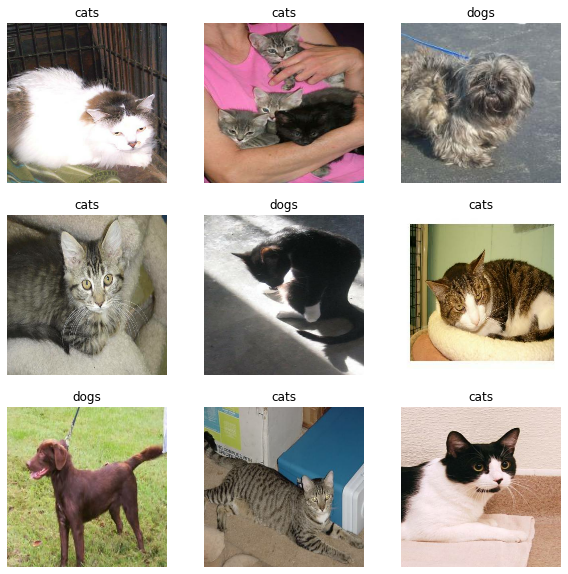

In [49]:
image_batch, label_batch = test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")